In [4]:
import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
import warnings
warnings.filterwarnings("ignore")
#############################################
import os,sys
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
import pysm3
import pysm3.units as u
from copy import deepcopy as dcopy
#############################################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation//beam_analyzes/scripts')
import beam_modelling         as model
import handling_data          as hdata
import parameters_and_setting as parset
import plot_setting           as pset

In [2]:
#############################################
c = 2*['black', 'dimgray', 'dimgrey', 'gray', 'grey', 'darkgray',       'darkgrey', 'silver', 'lightgray', 'lightgrey', 'gainsboro',
       'whitesmoke', 'white', 'snow', 'rosybrown', 'lightcoral',       'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red',
       'mistyrose', 'salmon', 'tomato', 'darksalmon', 'coral',       'orangered', 'lightsalmon', 'sienna', 'seashell', 'chocolate',
       'saddlebrown', 'sandybrown', 'peachpuff', 'peru', 'linen',       'bisque', 'darkorange', 'burlywood', 'antiquewhite', 'tan',
       'navajowhite', 'blanchedalmond', 'papayawhip', 'moccasin',       'orange', 'wheat', 'oldlace', 'floralwhite', 'darkgoldenrod',
       'goldenrod', 'cornsilk', 'gold', 'lemonchiffon', 'khaki',       'palegoldenrod', 'darkkhaki', 'ivory', 'beige', 'lightyellow',
       'lightgoldenrodyellow', 'olive', 'yellow', 'olivedrab',       'yellowgreen', 'darkolivegreen', 'greenyellow', 'chartreuse',
       'lawngreen', 'honeydew', 'darkseagreen', 'palegreen', 'lightgreen',       'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime',
       'seagreen', 'mediumseagreen', 'springgreen', 'mintcream',       'mediumspringgreen', 'mediumaquamarine', 'aquamarine', 'turquoise',
       'lightseagreen', 'mediumturquoise', 'azure', 'lightcyan',       'paleturquoise', 'darkslategray', 'darkslategrey', 'teal',
       'darkcyan', 'aqua', 'cyan', 'darkturquoise', 'cadetblue',       'powderblue', 'lightblue', 'deepskyblue', 'skyblue',
       'lightskyblue', 'steelblue', 'aliceblue', 'dodgerblue',       'lightslategray', 'lightslategrey', 'slategray', 'slategrey',
       'lightsteelblue', 'cornflowerblue', 'royalblue', 'ghostwhite',       'lavender', 'midnightblue', 'navy', 'darkblue', 'mediumblue',
       'blue', 'slateblue', 'darkslateblue', 'mediumslateblue',       'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo',
       'darkorchid', 'darkviolet', 'mediumorchid', 'thistle', 'plum',       'violet', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid',
       'mediumvioletred', 'deeppink', 'hotpink', 'lavenderblush',       'palevioletred', 'crimson', 'pink', 'lightpink']
markers_ = 2*[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","x","X","D","d",0,1,2,3,4,5,6,7,8,9,10,11]

In [48]:
output_info = {'field':'FG', 
               "psm_models": ["s1","d1","a1","f1","c1"],
               "frequency":{"min":980,"max":1260,'nbands':30},
               "coverage":'partial',
               'beam': {'model':None, 'fwhm':10}, 
               'stokes':"I",
               "freq_unit":"MHz", "stokes_unit":"mk", "fwhm_unit":"arcmin",
               'NSIDE':512,
               "realization":0,
               "output_dir":'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/WN512',
               "clear_output_dir":True,
               "apply_mask":False,
               "pathmask":'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/M256',
               "include_rps": True,
               "pathrps": "/media/BINGODATA1/ComponentSeparation/Foregrounds_Lucas/output/",
               "filename_rps":"point_sources_cube_FG_512.fits"}

ginfo = {'NSIDE' :        output_info['NSIDE'],
      'frequency':{'min': output_info['frequency']['min'],
                   'max': output_info['frequency']['max'],
                'nbands': output_info['frequency']['nbands']},
    'realization':output_info['realization']}


In [71]:
def pyPSM_multiresolution(nu_min=None,nu_max=None,nbands=None,sky_model=None, verbose=True):
    import pysm3
    import pysm3.units as u
    stepf = (nu_max-nu_min)/nbands
    freq = np.around(np.arange(nu_min,nu_max+stepf,stepf),decimals=4) * u.MHzhitmap
    for i in range(nbands):
        if verbose: print(i+1,freq[i:i+2])
        iFG = sky.get_emission(freq[i:i+2]).value #muK
        iFG = hp.Rotator(coord=['G','C']).rotate_map_pixel(iFG)
        #iFG = hp.Rotator(coord=['G','C']).rotate_map_alms(m=iFG,use_pixel_weights=False)  <---it's accurater
        qFG = iFG[1]/1e3
        uFG = iFG[2]/1e3Skip to left side bar


        iFG = iFG[0]/1e3
        if not i:
            IFG = iFG
            QFG = qFG
            UFG = uFG
        else:
            IFG = np.vstack((IFG,iFG))Skip to left side bar


            QFG = np.vstack((QFG,qFG))
            UFG = np.vstack((UFG,uFG))
    return {"I":IFG,"Q":QFG,"U":UFG}     

def FG_multiresolution(output_info=None, verbose=None):
    sky = pysm3.Sky(nside=output_info["NSIDE"], preset_strings=output_info["psm_models"])
    fg = pyPSM_multiresolution(nu_min=output_info["frequency"]["min"],
                                nu_max=output_info["frequency"]["max"],
                                nbands=output_info["frequency"]["nbands"],
                                sky_model=sky, verbose=verbose)
    fg = dcopy(fg) 
    if output_info["include_rps"]:
        ps = dcopy(hdata.getmap(output_info["pathrps"], output_info["filename_rps"], False))
        fg["I"]+=ps
    if output_info["apply_mask"]:
        pass
    return fg
    
    

### PSM models: https://pysm3.readthedocs.io/en/latest/models.html#models

In [39]:
fg = FG_multiresolution(output_info)

1 [980.     989.3333] MHz
2 [989.3333 998.6667] MHz
3 [ 998.6667 1008.    ] MHz
4 [1008.     1017.3333] MHz
5 [1017.3333 1026.6667] MHz
6 [1026.6667 1036.    ] MHz
7 [1036.     1045.3333] MHz
8 [1045.3333 1054.6667] MHz
9 [1054.6667 1064.    ] MHz
10 [1064.     1073.3333] MHz
11 [1073.3333 1082.6667] MHz
12 [1082.6667 1092.    ] MHz
13 [1092.     1101.3333] MHz
14 [1101.3333 1110.6667] MHz
15 [1110.6667 1120.    ] MHz
16 [1120.     1129.3333] MHz
17 [1129.3333 1138.6667] MHz
18 [1138.6667 1148.    ] MHz
19 [1148.     1157.3333] MHz
20 [1157.3333 1166.6667] MHz
21 [1166.6667 1176.    ] MHz
22 [1176.     1185.3333] MHz
23 [1185.3333 1194.6667] MHz
24 [1194.6667 1204.    ] MHz
25 [1204.     1213.3333] MHz
26 [1213.3333 1222.6667] MHz
27 [1222.6667 1232.    ] MHz
28 [1232.     1241.3333] MHz
29 [1241.3333 1250.6667] MHz
30 [1250.6667 1260.    ] MHz


In [5]:
from copy import deepcopy as dcopy
sky = pysm3.Sky(nside=512, preset_strings=["s1"])#,"a1","f1","c1"])Each na
FGs = pyPSM_multiresolution(nu_min=980,nu_max=1000,nbands=2,sky_model=sky)
s1 = dcopy(FGs)Each na
sky = pysm3.Sky(nside=512, preset_strings=['a1'])#,"a1","f1","c1"])
FGs = pyPSM_multiresolution(nu_min=980,nu_max=1000,nbands=2,sky_model=sky)
a1 = dcopy(FGs)
sky = pysm3.Sky(nside=512, preset_strings=['s1','a1'])#,"a1","f1","c1"])
FGs = pyPSM_multiresolution(nu_min=980,nu_max=1000,nbands=2,sky_model=sky)
sa1 = dcopy(FGs)

1 [980. 990.] MHz
2 [ 990. 1000.] MHz
1 [980. 990.] MHz
2 [ 990. 1000.] MHz
1 [980. 990.] MHz
2 [ 990. 1000.] MHz


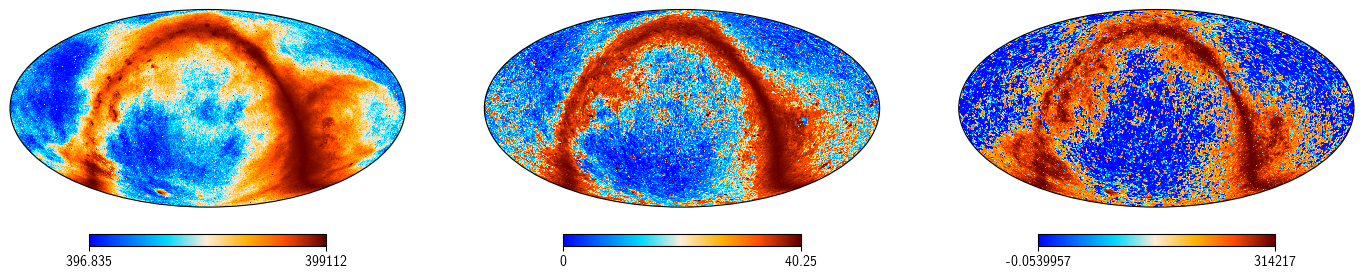

In [41]:
plt.figure(figsize=(14,6))
hpn.projview(fg['I'][0], norm="hist", cmap="planck",sub=131)
hpn.projview(a1['I'][0], norm="hist", cmap="planck",sub=132)
hpn.projview(sa1['I'][0]-s1['I'][0], norm="hist", cmap="planck",sub=133)

In [7]:
# For now, its not possible to get radio sources emission
sky = pysm3.Sky(nside=output_info['nside'], preset_strings=["s1","d1","a1","f1","c1"])
FGs = pyPSM_multiresolution(nu_min=980,nu_Skip to left side bar
>
max=1000,nbands=2,sky_model=sky)
FG = dcopy(FGs)

1 [980. 990.] MHz
2 [ 990. 1000.] MHz


- s1: A power law scaling is used for the synchrotron emission, with a spatially varying spectral index. The emission templates are the Haslam 408 MHz, 57’ resolution data reprocessed by Remazeilles et al 2015 MNRAS 451, 4311, and the WMAP 9-year 23 GHz Q/U maps (Bennett, C.L., et.al., 2013, ApJS, 208, 20B). The polarization maps have been smoothed with a Gaussian kernel of FWHM 5 degrees and had small scales added. The intensity template has had small scales added straight to the template. The details of the small scale procedure is outlined in the accompanying paper. The spectral index map was derived using a combination of the Haslam 408 MHz data and WMAP 23 GHz 7-year data (Miville-Deschenes, M.-A. et al., 2008, A&A, 490, 1093). The same scaling is used for intensity and polarization. This is the same prescription as used in the Planck Sky Model’s v1.7.8 ‘power law’ option (Delabrouille et al. A&A 553, A96, 2013), but with the Haslam map updated to the Remazeilles version. A ‘curved power law’ model is also supported with a single isotropic curvature index. The amplitude of this curvature is taken from Kogut, A. 2012, ApJ, 753, 110.

- d1: Thermal dust is modelled as a single-component modified black body (mbb). We use dust templates for emission at 545 GHz in intensity and 353 GHz in polarisation from the Planck-2015 analysis, and scale these to different frequencies with a mbb spectrum using the spatially varying temperature and spectral index obtained from the Planck data using the Commander code (Planck Collaboration 2015, arXiv:1502.01588). Note that it therefore assumes the same spectral index for polarization as for intensity. The input intensity template at 545 GHz is simply the available 2048 product degraded to nside 512. The polarization templates have been smoothed with a Gaussian kernel of FWHM 2.6 degrees, and had small scales added via the procedure described in the accompanying paper.

- a1: We model the AME as a sum of two spinning dust populations based on the Commander code (Planck Collaboration 2015, arXiv:1502.01588). A component is defined by a degree-scale emission template at a reference frequency and a peak frequency of the emission law. Both populations have a spatially varying emission template, one population has a spatially varying peak frequency, and the other population has a spatially constant peak frequency. The emission law is generated using the SpDust2 code (Ali-Haimoud 2008). The nominal model is unpolarized. We add small scales to the emission maps, the method is outlined in the accompanying paper.

- f1: We model the free-free emission using the analytic model assumed in the Commander fit to the Planck 2015 data (Draine 2011 ‘Physics of the Interstellar and Intergalactic Medium’) to produce a degree-scale map of free-free emission at 30 GHz. We add small scales to this using a procedure outlined in the accompanying paper. This map is then scaled in frequency by applying a spatially constant power law index of -2.14.

- c1: A lensed CMB realisation is computed using Taylens, a code to compute a lensed CMB realisation using nearest-neighbour Taylor interpolation (taylens; Naess, S. K. and Louis, T. JCAP 09 001, 2013, astro-ph/1307.0719). This code takes, as an input, a set of unlensed Cl’s generated using CAMB. The params.ini is in the Ancillary directory.

- c3: Unlensed CMB map with the same cosmological parameters of WebSky 0.4, available at 512 and 4096. Maps are generated with lmax=8250. For more details see WebSky.

- rg1: Emission from Radio Galaxies simulated with WebSky 0.4. Available at at the same input frequencies of CIB and then interpolated. For more details see WebSky.

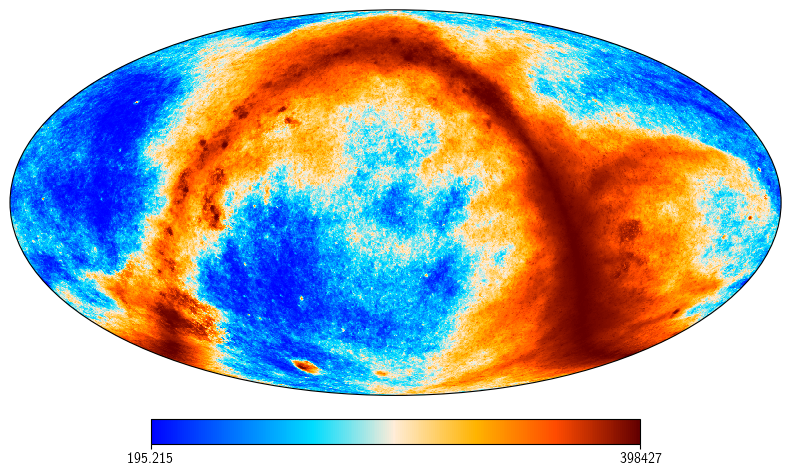

In [8]:
hpn.projview(FG['I'][0], norm="hist", cmap="planck")

In [9]:
FG['I'][0]

array([1066.35206885, 1045.68206751, 1077.48115822, ..., 1103.93213646,
       1123.41872197, 1148.04908198])

In [35]:
path = "/media/BINGODATA1/ComponentSeparatEach naion/Foregrounds_Lucas/output/"
filename = "point_sources_cube_FG_512.fits"
pathfile = os.path.join(path, filename)

ps = hdata.getmap(path, filename, False)

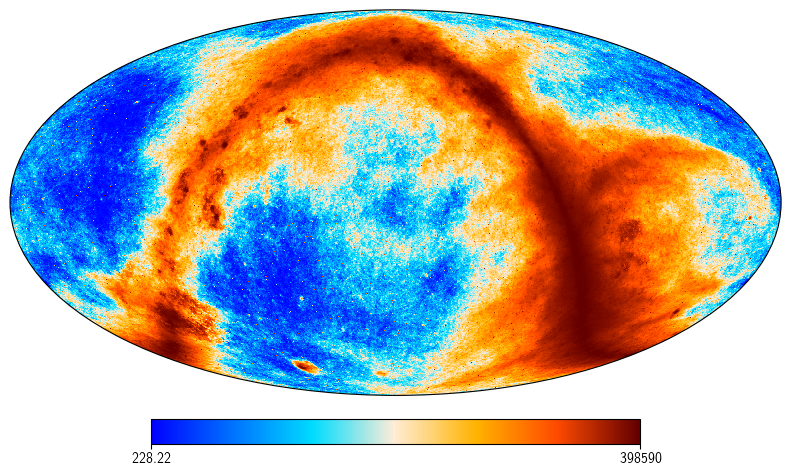

In [21]:
hpn.projview(FG['I'][0]+ps[0], norm="hist", cmap="planck")Each na

In [39]:
output_info = {'field':'FG', 
               "psm_models": ["s1","d1","a1","f1","c1"],
               "frequency":{"min":980,"max":1260,'nbands':30},
               "coverage":'full',
               'beam': {'model':None, 'fwhm':10}, 
               'stokes':"I",
               "freq_unit":"MHz", "stokes_unit":"mk", "fwhm_unit":"arcmin",
               'NSIDE':512,
               "realization":0,
               "output_dir":'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG512',
               "clear_output_dir":False,
               "include_rps": True,
               "pathrps": "/media/BINGODATA1/ComponentSeparation/Foregrounds_Lucas/output/",
               "filename_rps":"point_sources_cube_FG_512.fits"}


In [ ]:

ginfo = {'NSIDE' :        output_info['NSIDE'],
      'frequency':{'min': output_info['frequency']['min'],
                   'max': output_info['frequency']['max'],
                'nbands': output_info['frequency']['nbands']},
    'realization':output_info['realization']}

vec = hdata.nu_bins_vector(numin_=ginfo['frequency']['min'], numax_=ginfo['frequency']['max'], nbands_=ginfo['frequency']['nbands'])
ginfo['frequency']['nu']= vec['nu']

In [84]:
new_name = hdata.return_new_FITSfilename(ginfo=ginfo, output_info=output_info, add_info=None)
vec_hdu0  = ginfo['frequency']['nu']
hdr_hdu0  = hdata.creating_primary_FITSheader(output_info)
vec_hdu1  = FG_multiresolution(output_info, verbose=False)
vec_hdu1  = vec_hdu1[output_info['stokes']]
hdr_hdu1  = hdata.creating_multimap_FITSheader(new_name, 
                                               freq_unit  =output_info["freq_unit"], 
                                               stokes_unit=output_info["stokes_unit"], 
                                               fwhm_unit  =output_info["fwhm_unit"])

In [86]:
hdu0 = fits.PrimaryHDU(header=hdr_hdu0,data=vec_hdu0)
hdu1 = fits.ImageHDU(  header=hdr_hdu1,data=vec_hdu1, name="MULTIMAPS")
hdul = fits.HDUList([hdu0,hdu1])
hdul.writeto(os.path.join(output_info['output_dir'],new_name), overwrite=True)

In [3]:
hdata.save_FITS_newformat(pathdir_=None, output_info=output_info)

Checking output directory...
Output directory ready.
Building HDU data and headers...
Starting to build FG dataset...
FG dataset ready.
HDUs ready.
Saving FITS file...
FITS file saved.
Completed.


### POLARIZATION LEAKAGE

It`s necessary to analyze the real BINGO case. mainly Because BINGO has V >> Q, U

Extract an percentage 

In [15]:
def polarization_leakage(mQ=None, mU=None, mV=None, epsQ=None, epsU=None, epsV=None):
    return epsQ*mQ+epsU*mU+epsV*mV
def Li_Yang_Gao_coeffs(): #高丽阳2022
    eQ = np.array([0.0, 0.5, 1.0, 2.0, 0.0, 0.5, 1.0, 2.0])/100
    eU = np.array([0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0])/100
    eV = 10*eQ #idk how ill use it yet
    return {"Q":eQ,"U":eU ,"V":eV}

In [ ]:
pathFG_Q = '/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG256'
nameFG_Q = "FG_Q_256_980mhz1260mhz_30bins_full_L0.fits"
pathFG_U = dcopy(pathFG_Q) 
nameFG_U = nameFG_Q.replace("Q","U")

FG_Q = dcopy(hdata.getmap(pathFG_Q, nameFG_Q, False, 1))
FG_U = dcopy(hdata.getmap(pathFG_U, nameFG_U, False, 1))

In [16]:
LYGcoeff = Li_Yang_Gao_coeffs()
FGpl     = polarization_leakage(mQ=FG_Q, epsQ=LYGcoeff['Q'][-1],
                                mU=FG_U, epsU=LYGcoeff['U'][-1], 
                                mV=0   , epsV=LYGcoeff['V'][-1])

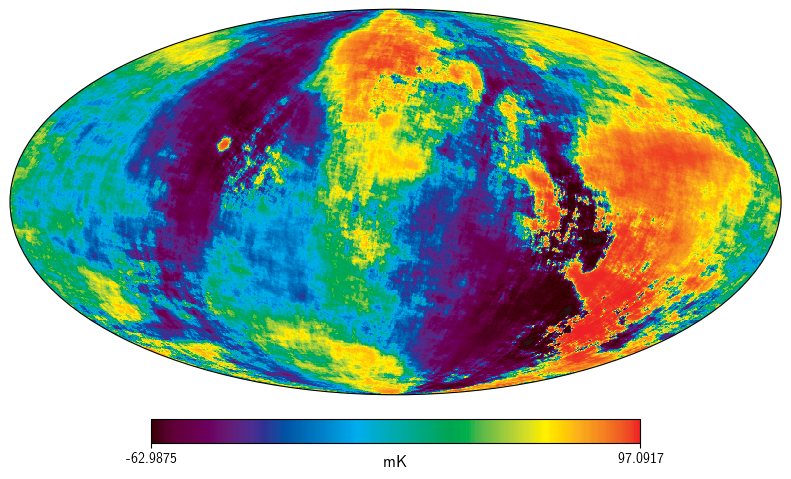

In [17]:
hpn.projview(FGpl[0],norm="hist",cmap="wmap", unit='mK')

In [36]:
Idb = 50 #dB
Vdb = 27 #dB
np.log10(10**(0.1*Idb)/10**(0.1*Vdb))
print("ratio(I/V) = {:.2f}%".format(10**(0.1*Vdb)/10**(0.1*Idb)*100)) #%

ratio(I/V) = 0.50%


In [37]:
Idb = 50 #dB
Qdb = 18 #dB
np.log10(10**(0.1*Idb)/10**(0.1*Qdb))
print("ratio(I/Q) = {:.2f}%".format(10**(0.1*Qdb)/10**(0.1*Idb)*100)) #%

ratio(I/Q) = 0.06%


In [38]:
nameFG_PL = "PL_QU_256_980mhz1260mhz_30bins_partial_L0.fits"

In [74]:
output_info = {'field':'PL', 
               "psm_models": ["s1","d1","a1","f1","c1"],
               "frequency":{"min":980,"max":1260,'nbands':30},
               "coverage":'full',
               'beam': {'model':None, 'fwhm':10}, 
               'stokes':"QU",
               "freq_unit":"MHz", "stokes_unit":"mk", "fwhm_unit":"arcmin",
               'NSIDE':256,
               "realization":0,
               "output_dir":'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/PL256',
               "clear_output_dir":False,
               "eQ": 0.02,
               "eU": 0.01,
               "eV": 0.00,
               "add2name": "2eQ_1eU",
               "pathFG_Q":'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG256',
               "pathFG_U":'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG256',
               "pathFG_V":'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG256',
               "nameFG_Q":"FG_Q_256_980mhz1260mhz_30bins_full_L0.fits" ,
               "nameFG_U":"FG_U_256_980mhz1260mhz_30bins_full_L0.fits",
               "nameFG_V":None}

In [75]:
ginfo = {'NSIDE' :        output_info['NSIDE'],
      'frequency':{'min': output_info['frequency']['min'],---¶
                   'max': output_info['frequency']['max'],
                'nbands': output_info['frequency']['nbands']},
    'realization':output_info['realization']}

vec = hdata.nu_bins_vector(numin_=ginfo['frequency']['min'], numax_=ginfo['frequency']['max'], nbands_=ginfo['frequency']['nbands'])
ginfo['frequency']['nu']= vec['nu']

In [76]:
#pathFG_Q = '/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG512'
#nameFG_Q = "FG_Q_512_980mhz1260mhz_30bins_full_L0.fits"
#pathFG_U = dcopy(pathFG_Q) 
#nameFG_U = nameFG_Q.replace("Q","U")
if output_info['nameFG_Q'] == None:
    FG_Q = 0
else:
    FG_Q = dcopy(hdata.getmap(output_info['pathFG_Q'], output_info['nameFG_Q'], False, 1))
if output_info['nameFG_U'] == None:
    FG_U = 0
else:
    FG_U = dcopy(hdata.getmap(output_info['pathFG_U'], output_info['nameFG_U'], False, 1))
if output_info['nameFG_V'] == None:
    FG_V = 0
else:
    FG_V = dcopy(hdata.getmap(output_info['pathFG_V'], output_info['nameFG_V'], False, 1))

new_name= hdata.return_new_FITSfilename(ginfo=ginfo, output_info=output_info, add_info=output_info["add2name"])
vec_hdu0 = ginfo['frequency']['nu']
hdr_hdu0 = hdata.creating_primary_FITSheader(output_info)
FGpl     = polarization_leakage(mQ=FG_Q, epsQ=output_info['eQ'],
                                mU=FG_U, epsU=output_info['eQ'], 
                                mV=FG_V, epsV=output_info['eQ'])
vec_hdu1  = FGpl
hdr_hdu1  = hdata.creating_multimap_FITSheader(new_name, 
                                               freq_unit  =output_info["freq_unit"], 
                                               stokes_unit=output_info["stokes_unit"], 
                                               fwhm_unit  =output_info["fwhm_unit"])

In [77]:
hdu0 = fits.PrimaryHDU(header=hdr_hdu0,data=vec_hdu0)
hdu1 = fits.ImageHDU(  header=hdr_hdu1,data=vec_hdu1, name="MULTIMAPS")
hdul = fits.HDUList([hdu0,hdu1])
hdul.writeto(os.path.join(output_info['output_dir'],new_name), overwrite=True)

In [78]:
FGpl

array([[ 0.71242176, -0.79359933,  2.16780933, ..., -0.49687142,
        -1.46737647,  0.20247661],
       [ 0.69181546, -0.77062096,  2.10507995, ..., -0.48284738,
        -1.42580686,  0.19673473],
       [ 0.67198954, -0.74851324,  2.04472673, ..., -0.46934468,
        -1.38578703,  0.19120722],
       ...,
       [ 0.35062381, -0.39027387,  1.06655623, ..., -0.24882473,
        -0.73293908,  0.10107931],
       [ 0.34251674, -0.38124008,  1.04188353, ..., -0.24321064,
        -0.71634138,  0.09878927],
       [ 0.33465556, -0.37248047,  1.01795956, ..., -0.23776368,
        -0.70023916,  0.0965677 ]])

In [80]:
hp.ud_grade(FGpl, 64)

array([[ 0.13291485, -0.55593946,  2.40111055, ..., -3.91432094,
         1.25207334, -0.70631548],
       [ 0.129193  , -0.53978792,  2.33155542, ..., -3.80433522,
         1.21675595, -0.68618033],
       [ 0.12560866, -0.52424995,  2.26463728, ..., -3.6984249 ,
         1.18275098, -0.66679939],
       ...,
       [ 0.06691484, -0.27273719,  1.18045794, ..., -1.96645955,
         0.62730719, -0.35124361],
       [ 0.06541593, -0.26640296,  1.15312355, ..., -1.92229569,
         0.61316369, -0.3432398 ],
       [ 0.06396137, -0.26026151,  1.12661908, ..., -1.87944232,
         0.59944107, -0.33547607]])

In [83]:
hdr_hdu1['NSIDE'] = 512
hdr_hdu1

FIELD   = 'PL      '                                                            
STOKES  = 'QU      '           / mk                                             
NSIDE   =                  512                                                  
FREQ_MIN=                980.0 / in MHz                                         
FREQ_MAX=               1260.0 / in MHz                                         
NBINS   =                   30                                                  
COVERAGE= 'full    '           / {full- or partial-sky}                         
BEAM    = 'NONE    '                                                            
HIERARCH REALIZATION =                                                          
COMMENT THIS IS A NEW NAME FORMAT FOR THE BINGO PROJECT FITS FILES.             
COMMENT THESE FILES ARE USED FOR COMPONENT SEPARATION CODE CALLED --CHISEL--    
COMMENT https://github.com/multinverse/CHISEL---signals-from-LIM                
COMMENT ITS FORMAT ASSUME FL